In [77]:
import pandas as pd
from multiprocessing import Pool, Process, Queue, current_process, parent_process
from datetime import datetime
# import time 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

In [78]:
m5_data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)

In [79]:
m5_data.columns = col_name =['target', 'ids', 'date', 'flag', 'user', 'text']

In [80]:
for col in col_name:
    print(m5_data[col].unique())

[0 4]
[1467810369 1467810672 1467810917 ... 2193601991 2193602064 2193602129]
['Mon Apr 06 22:19:45 PDT 2009' 'Mon Apr 06 22:19:49 PDT 2009'
 'Mon Apr 06 22:19:53 PDT 2009' ... 'Tue Jun 16 08:38:58 PDT 2009'
 'Tue Jun 16 08:39:00 PDT 2009' 'Tue Jun 16 08:40:50 PDT 2009']
['NO_QUERY']
['_TheSpecialOne_' 'scotthamilton' 'mattycus' ... 'EvolveTom'
 'AmandaMarie1028' 'bpbabe']
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 ... 'Are you ready for your MoJo Makeover? Ask me for details '
 'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur '
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']


## Î∂ÑÏÑù Í≤∞Í≥º : 
* 'flag' Ìï≠Î™©ÏùÄ drop Í∞ÄÎä•
* neutral sentimentÎäî ÏóÜÎã§.
  * 1~800,000 ÎùºÏù∏ = Í∏çÏ†ï, Í∑∏ Îí§Î°ú Î∂ÄÏ†ï

In [81]:
def remove_stopwords(text):
    """WordCloud STOPWORDSÎ•º ÏÇ¨Ïö©Ìï¥ Î∂àÏö©Ïñ¥ Ï†úÍ±∞"""
    stopwords = set(STOPWORDS)  # WordCloudÏùò STOPWORDS ÏßëÌï© Í∞ÄÏ†∏Ïò§Í∏∞
    words = text.split()  # ÌÖçÏä§Ìä∏Î•º Îã®Ïñ¥Î°ú Î∂ÑÎ¶¨
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)  # Îã®Ïñ¥Î•º Îã§Ïãú Ìï©ÏπòÍ∏∞

In [82]:
def preprocess(txt: str) -> str:
    """
    Preprocess Twitter text data.
    ÏùºÎ∞òÏ†ÅÏù∏ ÌÖçÏä§Ìä∏ Ïù¥Î™®ÏßÄÍ∞Ä 2~3characterÏóê 3Ïó∞ÏÜç characterÏù∏ Í≤ÉÏùÄ ÏóÜÎã§Í≥† Í∞ÄÏ†ï
    Args: txt (str): Original text from a tweet
    Return: (str): Cleaned and preprocessed text
    1. ÎßÅÌÅ¨Ìòï ÌÖçÏä§Ìä∏ ÏÇ≠Ï†ú
    2. @~~ ÏÇ≠Ï†ú
    3. Î¨∏Ïû•Î∂ÄÌò∏ ÏÇ≠Ï†ú (Ïó∞ÏÜçÎêú ÎßàÏπ®Ìëú Îì±Îì±) ‚Äî> You‚Äôre Í∞ôÏùÄÍ≤å Íπ®Ï†∏Î≤ÑÎ¶¨ÎäîÏßÄ Ïú†Ïùò (Î≥¥ÌÜµ Î∂àÏö©Ïñ¥Î°ú Ï≤òÎ¶¨ÎêòÏñ¥ ÏûàÏùå)
    4. &amp &quot &gt &lt ‚Äî> ÏÇ≠Ï†ú
    5. ÌÖçÏä§Ìä∏ Ïù¥Î™®Ìã∞ÏΩòÏùÄ Ïñ¥ÎñªÍ≤å??  :), ;),  ^^, ~_~, Îì±Îì±
    6. ÏïàÎ≥¥Ïù¥Îäî Ïù¥Ïä§ÏºÄÏù¥ÌîÑ Î¨∏Ïûê? (57915 ÎùºÏù∏Ïóê Ï°¥Ïû¨) ‚Äî> Ï†úÎ°ú ÎÑàÎπÑ Î¨∏Ïûê?Ïù∏ ÎìØ
    """
    # 0. ÌÖçÏä§Ìä∏ Ïù¥Î™®Ìã∞ÏΩò Ï≤òÎ¶¨ (Î≥¥Ï°¥)
    # Ïù¥Î™®Ìã∞ÏΩò Ìå®ÌÑ¥
    emoji_pattern = r"[:;=8][-~]?[)D\(\[\]pP]|[\^]{2,}|~_~|T_T|xD|<3|:-?o|:-?O"
    emojis = re.findall(emoji_pattern, txt)  # Ïù¥Î™®Ìã∞ÏΩò Ï∂îÏ∂ú
    txt = re.sub(emoji_pattern, " ", txt)    # ÏõêÎ¨∏ÏóêÏÑú Ï†úÍ±∞ ÌõÑ Î≥¥Ï°¥

    # 1. ÎßÅÌÅ¨Ìòï ÌÖçÏä§Ìä∏ ÏÇ≠Ï†ú
    txt = re.sub(r"http\S+|www.\S+|https\S+", "", txt, flags=re.MULTILINE)
    
    # 2. @twitter_id ÏÇ≠Ï†ú
    txt = re.sub(r"@\w+", "", txt)
    
    # 3. Î¨∏Ïû•Î∂ÄÌò∏ ÏÇ≠Ï†ú (Ïó∞ÏÜçÎêú ÎßàÏπ®Ìëú Ìè¨Ìï®)
    txt = re.sub(r"[.,!?;:'\"()\[\]{}\-‚Äî‚Ä¶]+", " ", txt)
    
    # 4. ÌäπÏàò HTML ÏóîÌã∞Ìã∞ ÏÇ≠Ï†ú
    txt = re.sub(r"&amp|&quot|&gt|&lt|&nbsp;", "", txt)
    
    # 5. Íπ®ÏßÑ Ïù¥Ïä§ÏºÄÏù¥ÌîÑ Î¨∏Ïûê Î∞è Í≥µÎ∞± Ï†úÍ±∞
    txt = re.sub(r"[\u200B-\u200D\uFEFF]", "", txt)  # Zero-width Î¨∏Ïûê Ï†úÍ±∞
    txt = re.sub(r"\s+", " ", txt).strip()           # Ï§ëÎ≥µ Í≥µÎ∞± Ï†úÍ±∞
    
    # ÏµúÏ¢Ö ÌÅ¥Î¶∞ ÌÖçÏä§Ìä∏ ÏÉùÏÑ±
    return " ".join(txt.split() + emojis)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞
tweet = "Hello @user! Check this out: https://example.com üòä üòä ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com"

# Í≤∞Í≥º Ï∂úÎ†•
print("Original text: ", tweet)
print("Preprocessed txt: ", preprocess(tweet))


Original text:  Hello @user! Check this out: https://example.com üòä üòä ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com
Preprocessed txt:  Hello Check this out üòä üòä Goodbye ^^ T_T ~_~


In [83]:
pos_data = m5_data[m5_data['target']==4][['text']]
neg_data = m5_data[m5_data['target']==0][['text']]

In [84]:
import numpy as np

vectorized_stopwords = np.vectorize(remove_stopwords)
vectorized_process = np.vectorize(preprocess)
pos_data['text'] = vectorized_stopwords(pos_data['text'])
pos_data['text'] = vectorized_process(pos_data['text'])

neg_data['text'] = vectorized_stopwords(neg_data['text'])
neg_data['text'] = vectorized_process(neg_data['text'])

In [85]:
wc = WordCloud()

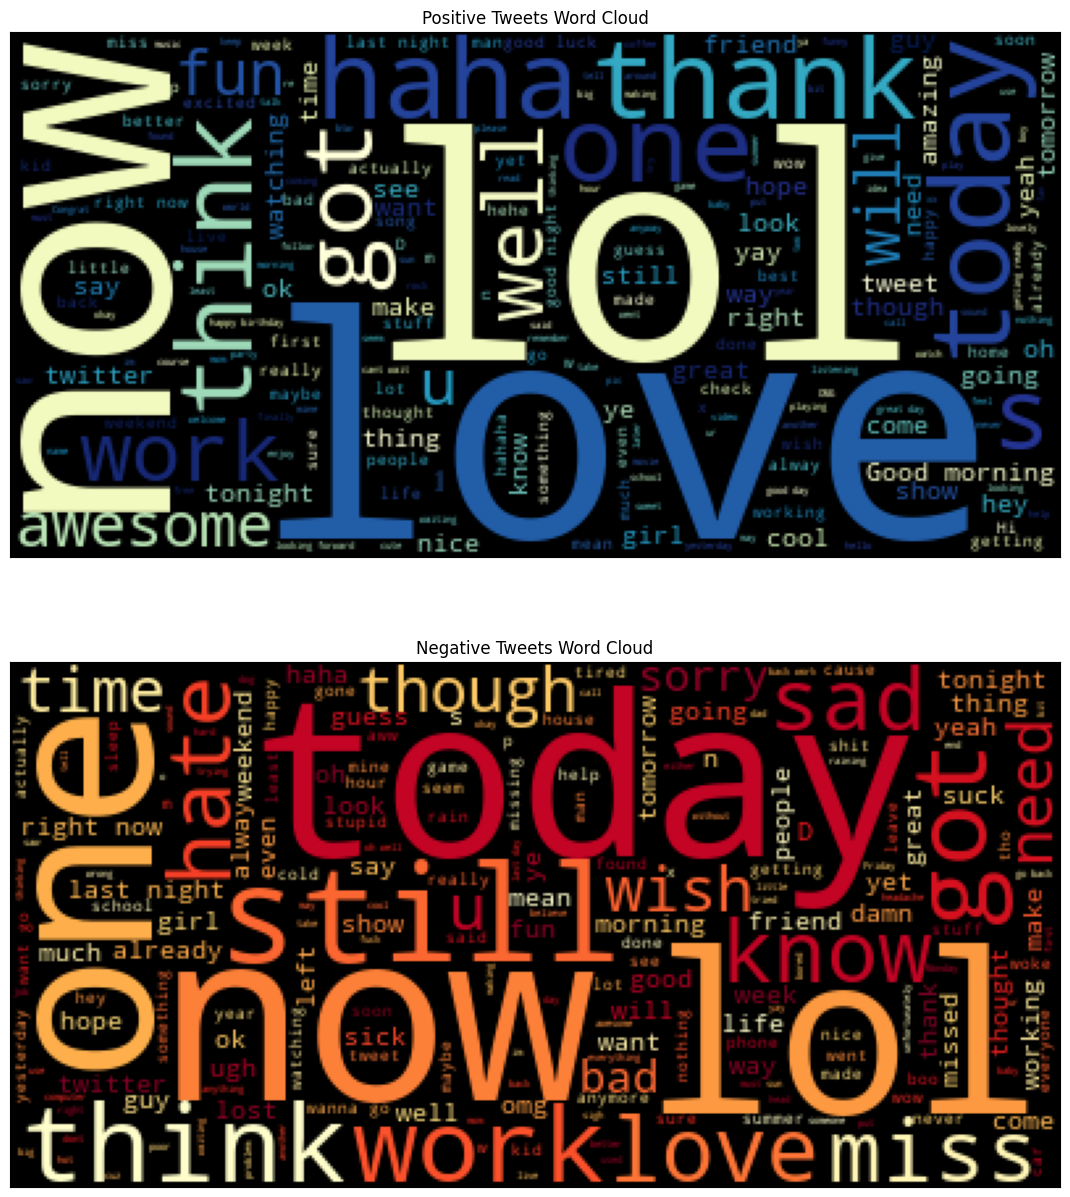

In [86]:
pos_txt = ' '.join(pos_data['text'])
# pos_dict = wc.generate(pos_txt).words_
neg_txt = ' '.join(neg_data['text'])

fig, axs = plt.subplots(2, 1, figsize = (15,15))
axs[0].imshow(WordCloud(max_words=200, colormap='YlGnBu').generate(pos_txt))
axs[0].yaxis.set_visible(False)
axs[0].xaxis.set_visible(False)
axs[0].set_title("Positive Tweets Word Cloud")

axs[1].imshow(WordCloud(max_words=200, colormap='YlOrRd').generate(neg_txt))
axs[1].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].set_title("Negative Tweets Word Cloud")

plt.show()

-------

# Sampling Process

In [87]:
from collections import Counter

In [88]:
pos_list = [word.lower() for text in pos_data['text'] for word in text.split()]
neg_list = [word.lower() for text in neg_data['text'] for word in text.split()]

In [89]:
pos_dict = Counter(pos_list)

In [90]:
neg_dict = Counter(neg_list)

## Í≥µÌÜµ Ï∂úÌòÑ Îã®Ïñ¥ Ï§ë Ï∂úÌòÑ ÌöüÏàòÏùò Ï†àÎåìÍ∞íÏù¥ Í∏∞Ï§ÄÍ∞í Ïù¥ÌïòÏù∏ Îã®Ïñ¥Îì§ÏùÑ Ï†úÏô∏ÌïòÎäî Í≥ºÏ†ï

In [91]:
common_key = set(pos_dict.keys()) & set(neg_dict.keys())

In [92]:
len(common_key)

85681

In [93]:
diff_senti = {}
for c in common_key:
    diff_senti[c] = abs(pos_dict[c] - neg_dict[c])

In [94]:
diff_avg = np.average(list(diff_senti.values()))
print("diff_avg: ", diff_avg)

diff_std = np.std(list(diff_senti.values()))
print("diff_std: ", diff_std)

diff_avg:  31.210279992063583
diff_std:  391.52938685888796


In [95]:
threshold = diff_avg + diff_std * 2
print(threshold)

814.2690537098395


In [96]:
# Ï†úÏô∏Ìï† Îã®Ïñ¥Îì§ Î™©Î°ù ÏÑ†Ï†ï
diff_senti = {k : v for k, v in diff_senti.items() if abs(pos_dict[k] - neg_dict[k]) <= (threshold)}

In [97]:
pos_pure = {}
for k, v in pos_dict.items():
    if k not in diff_senti:
        pos_pure[k] = v
        
neg_pure = {}
for k, v in neg_dict.items():
    if k not in diff_senti: 
        neg_pure[k] = v


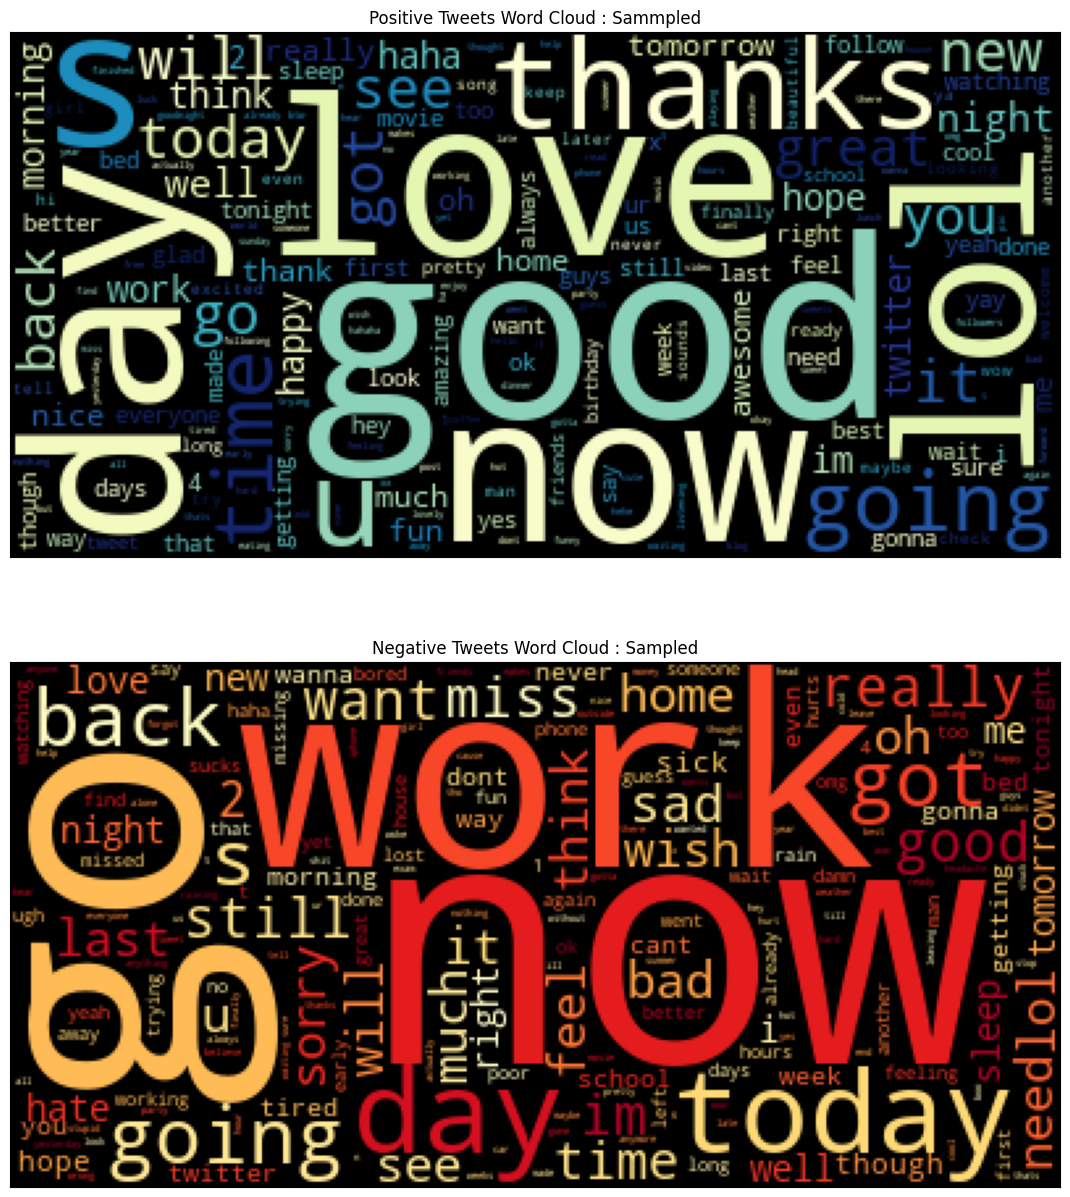

In [98]:
fig, axs = plt.subplots(2, 1, figsize = (15,15))
axs[0].imshow(WordCloud(max_words=200, colormap='YlGnBu').generate_from_frequencies(pos_pure))
axs[0].yaxis.set_visible(False)
axs[0].xaxis.set_visible(False)
axs[0].set_title("Positive Tweets Word Cloud : Sammpled")

axs[1].imshow(WordCloud(max_words=200, colormap='YlOrRd').generate_from_frequencies(neg_pure))
axs[1].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].set_title("Negative Tweets Word Cloud : Sampled")

plt.show()

------